In [1]:
# Imports
import os
from __future__ import print_function
import time
import warnings
warnings.filterwarnings('ignore')
os.environ['KERAS_BACKEND']='tensorflow'

# UTILS
from HANutils import resfromdict, normPSSM, getconsensus, Kldivergence, get_activations,draw_logo, HSW
import _pickle as cPickle
import pandas as pd

import os, operator
import numpy, math, random
import warnings

import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import normalize

# Graphics
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import seaborn 

# Seed for reproducibility
numpy.random.seed(8)


In [2]:
# Open saved values from HAN_get_PSSM
SEQ, consensus = cPickle.load(open("C:/Users/priya/ORNL summerr project/Priyanka-shared/codes/SEQ3_PF00595.pkl","rb"))
# Distance info
print("[!] Data sucessfully loaded")
print("SEQ shape: " , len(SEQ),len(SEQ[1]))
print("Consensus", consensus)

# Data format for keras: (number_of_sequences,lenght_of_sequences,number_of_features)
# Manual Tokenizer
CHARS = list(['-','L','V','I','M','C','A','G','S','T','P','F','Y','W','E','D','N','Q','K','R','H'])
DCHARS = {'-':0,'L':1,'V':2,'I':3,'M':4,'C':5,'A':6,'G':7,'S':8,'T':9,'P':10,'F':11,'Y':12,'W':13,'E':14,'D':15,'N':16,'Q':17,'K':18,'R':19,'H':20}
VOCAB_SIZE = len(DCHARS)
SEQ_LENGTH=len(SEQ[1])

[!] Data sucessfully loaded
SEQ shape:  12886 81
Consensus RIVIHRGSTGLGFNIIGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYK


In [3]:
## Files to load
# res_attn  residue attention
# res_model output res model (pre traiing)
# seq_output output of the dense 1
# resi window residue array
attn1 = numpy.loadtxt("C:/Users/priya/ORNL summerr project/res1/han/output/act.csv",  delimiter=",")
attn1 = attn1.reshape((attn1.shape[0],1))
attn1 = normalize(attn1,norm='max',axis=0).ravel()
# dist1 = numpy.loadtxt("res1/HAN/output/distance.csv",  delimiter=",")
resi1 = numpy.loadtxt("C:/Users/priya/ORNL summerr project/res1/han/output/resi.csv", delimiter=",")

In [4]:
#=================================================#
#   VISUALIZE ACTIVATIONS                         #
#   TRANSFER TO UTILS                             #
#=================================================#
%matplotlib inline
plt.style.use('seaborn-ticks')
# seaborn.set_palette("husl")

#=================================================#
#   ACTIVATION FROM LAYERS                        #
#=================================================#
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

#=================================================#
#   CONSENSUS PLOTTING                            #
#=================================================#
from matplotlib import transforms
import matplotlib.patheffects
from matplotlib.font_manager import FontProperties
import matplotlib as mpl



class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

def draw_logo(L, SEQUENCE, ACT, fontfamily='Arial', size=90):
    all_scores = dict(zip(list(numpy.arange(L)), ACT))
 
    if fontfamily == 'xkcd':
        plt.xkcd()
    else:
        mpl.rcParams['font.family'] = fontfamily

    fig, ax = plt.subplots(figsize=(60,20),dpi=300)

    font = FontProperties()
    font.set_size(size)
#     font.set_weight('bold')
    
    #font.set_family(fontfamily)

    ax.set_xticks(range(1,L+1))    
    ax.set_yticks(range(0,1))
    ax.set_xticklabels(range(START,L+START), rotation=90, fontsize=12) 
    ax.set_yticklabels(numpy.arange(0,max(ACT),1), fontsize=12) 
    ax.set_xticklabels(xticks, rotation=90, fontsize=40);
    seaborn.despine(ax=ax, trim=True)
    
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='dots')
   
    for index, scores in enumerate(all_scores):
        yshift = 0
        txt = ax.text(index+1, 
                      0, 
                      str(SEQUENCE[index]), 
#                       transform=trans_offset,
                      fontsize=80,# color=COLOR_SCHEME[base],
                      ha='center',
                      fontproperties=font
                     )
        
        txt.set_path_effects([Scale(.8, dictionary[scores]*10)])
        fig.canvas.draw()
        window_ext = txt.get_window_extent(txt._renderer)
        yshift = window_ext.height*dictionary[scores]
        trans_offset = transforms.offset_copy(txt._transform, 
                                              fig=fig,
                                              y=yshift,
                                              units='points')
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='points')    
    plt.show()
    


(0, 1)

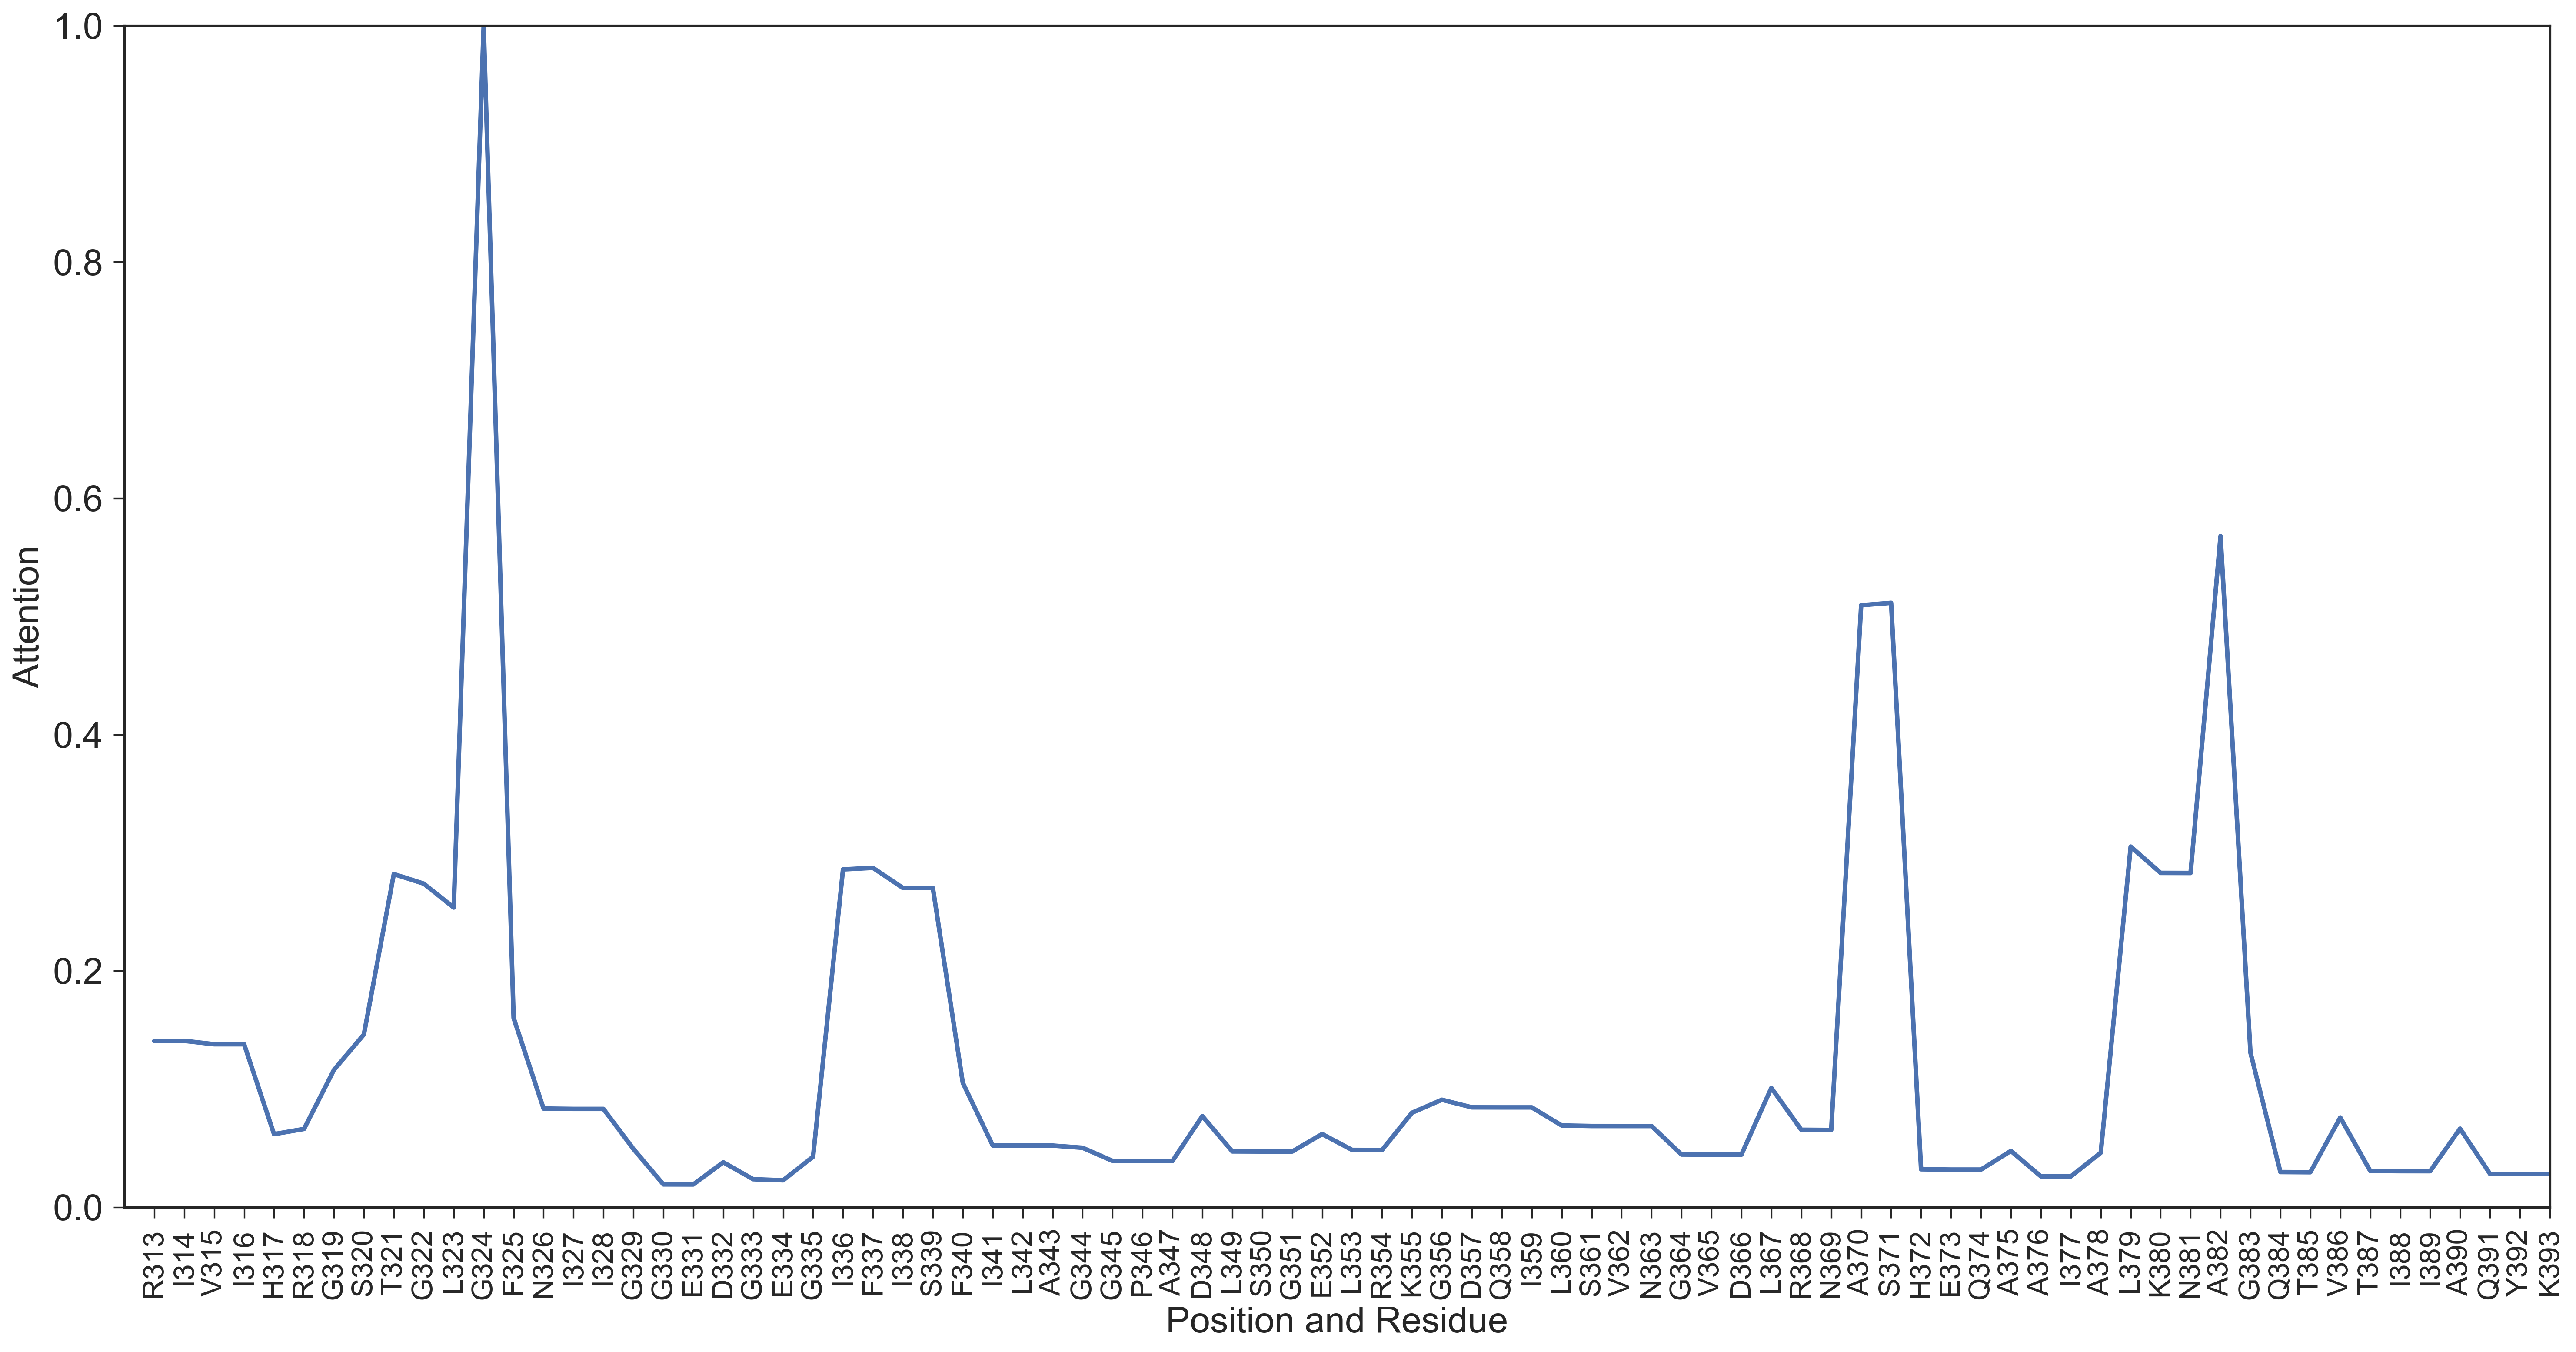

In [5]:
# HANprot Activation Plot
START=313
SEQ_LENGTH=attn1.shape[0]
RES=[consensus]
nums = numpy.arange(0,SEQ_LENGTH,1);
xticks = [(RES[0][i-START]+str(int(i))) for i in range(START,SEQ_LENGTH+START)]
seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})

f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=[attn1]);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

(0, 1)

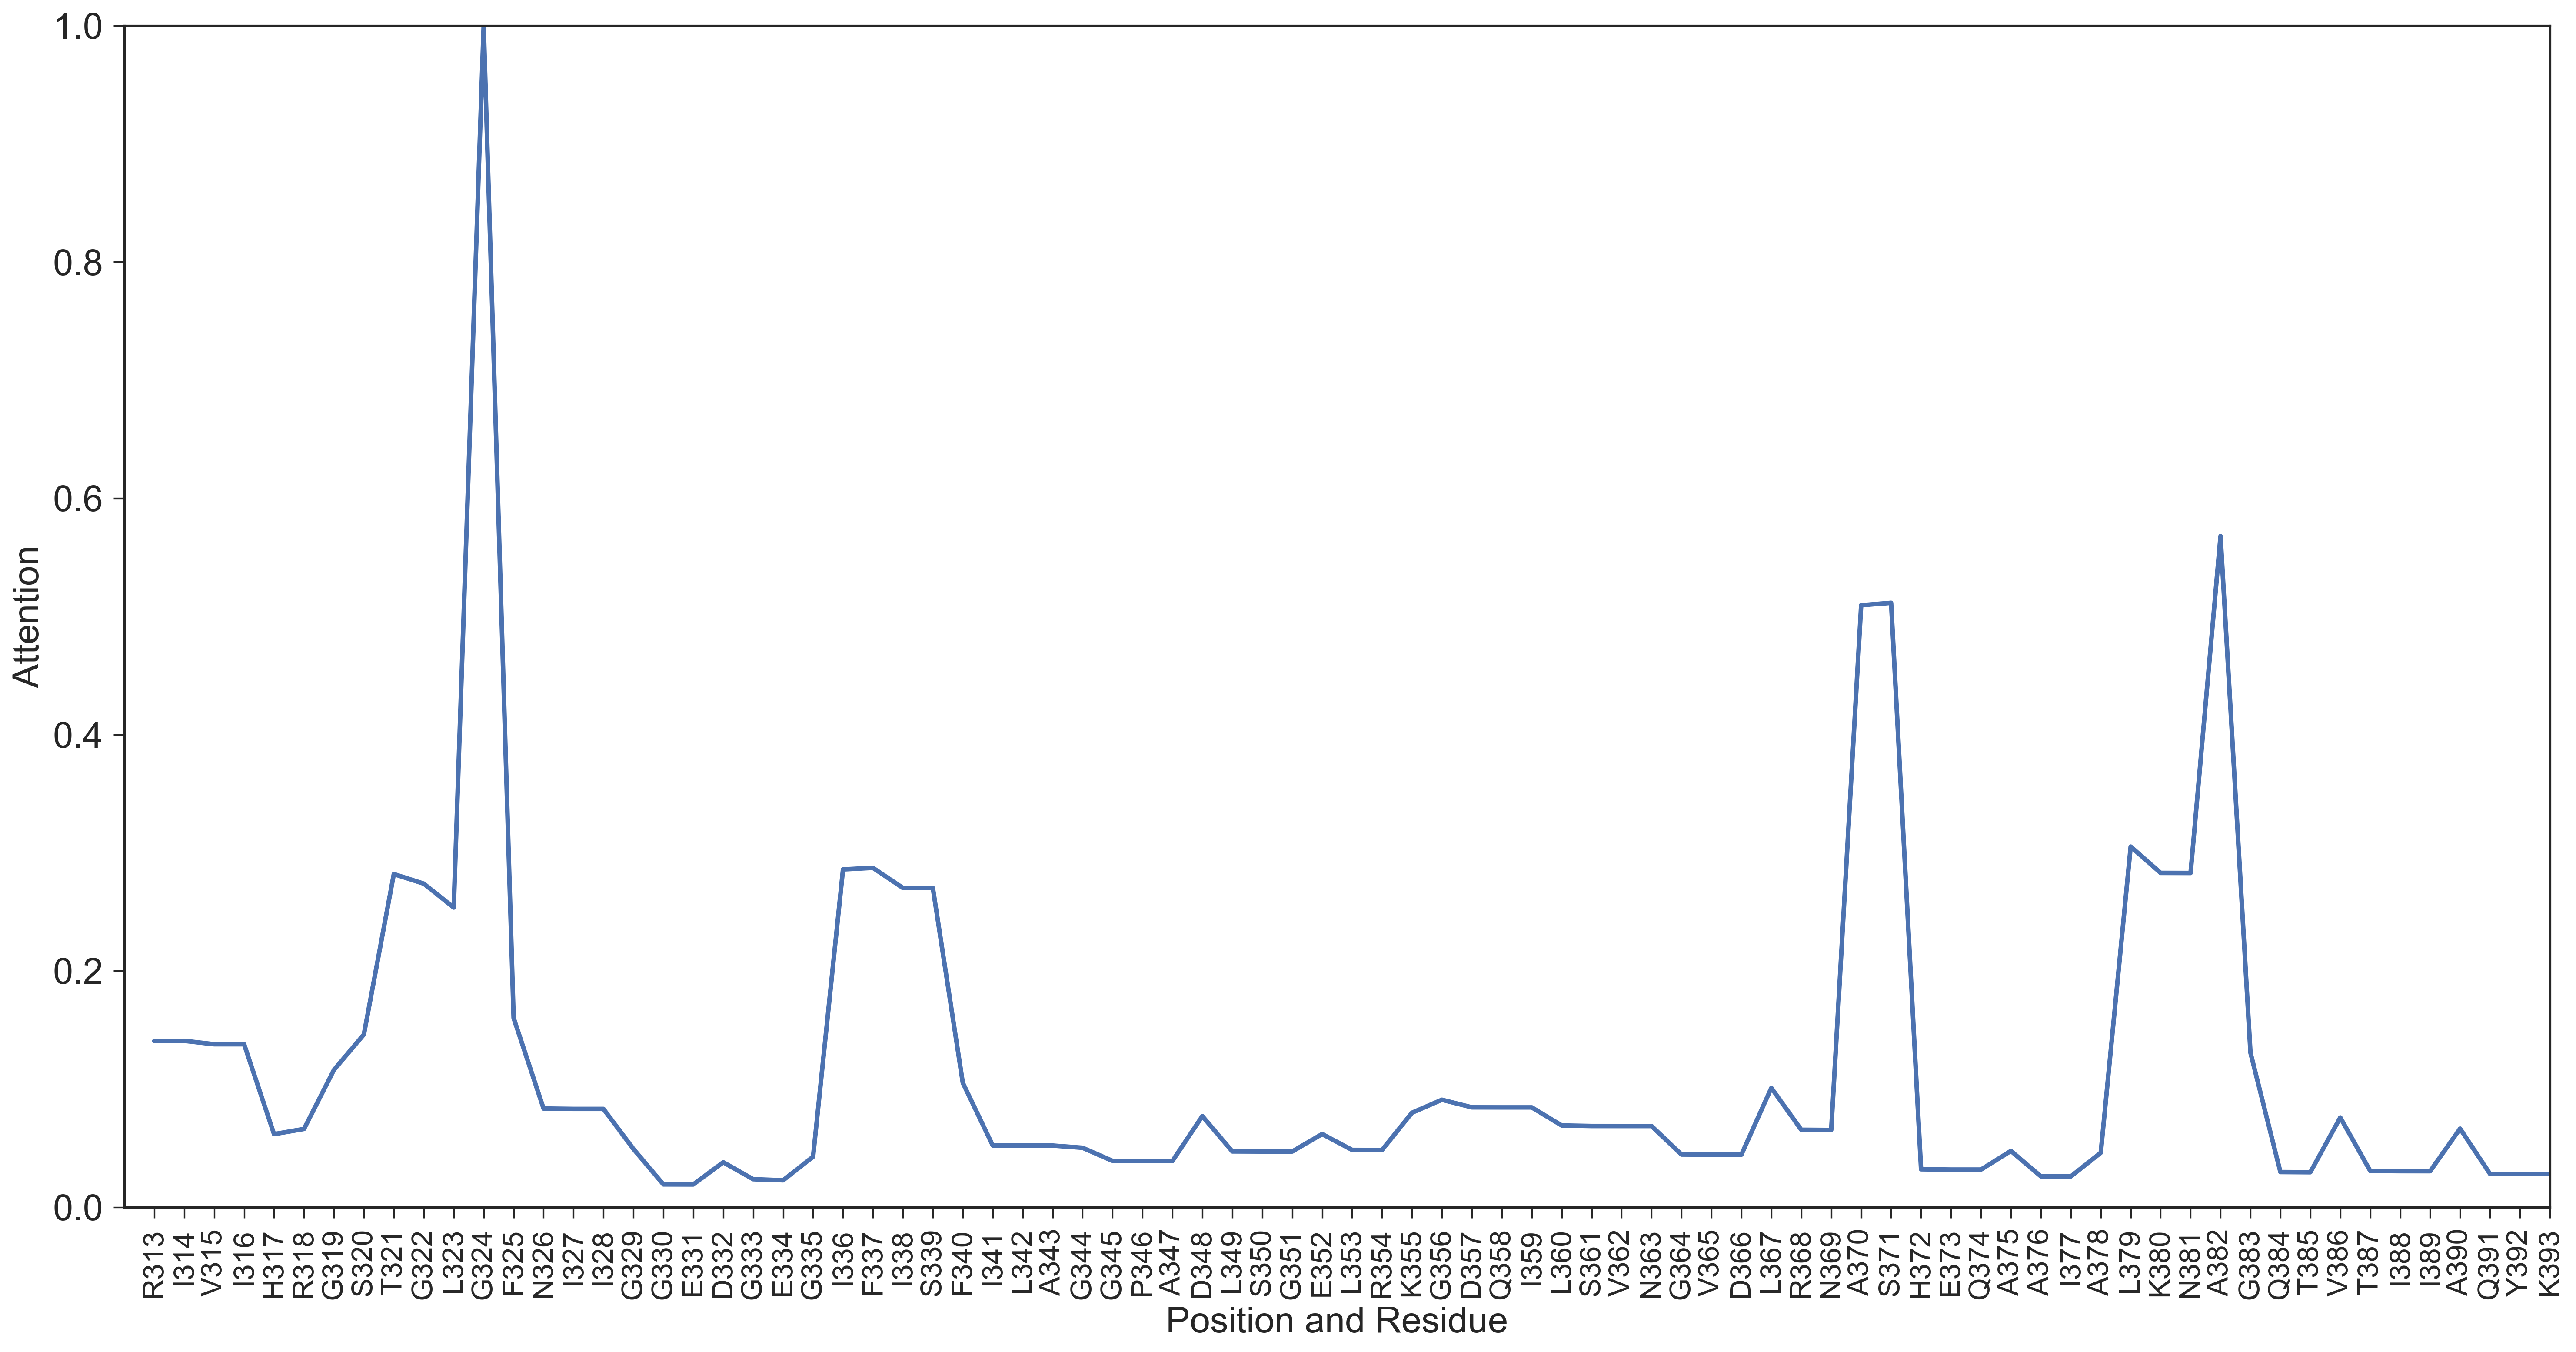

In [6]:
# Sequence Logo and HANprot result
compdata = numpy.mean([attn1], axis=0)
data=normalize(attn1.reshape((1,attn1.shape[0])),norm='max')#,

# data=numpy.mean(data,axis=0)
data_=attn1
data2 = numpy.tril(data_)

seq_dict = numpy.arange(SEQ_LENGTH)
dictionary = dict(zip(list(seq_dict), data_))    
draw_logo(SEQ_LENGTH,RES[0],data_, 'Arial')

# Normalize Attn array
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=compdata);
ax.set_ylabel("Attention", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

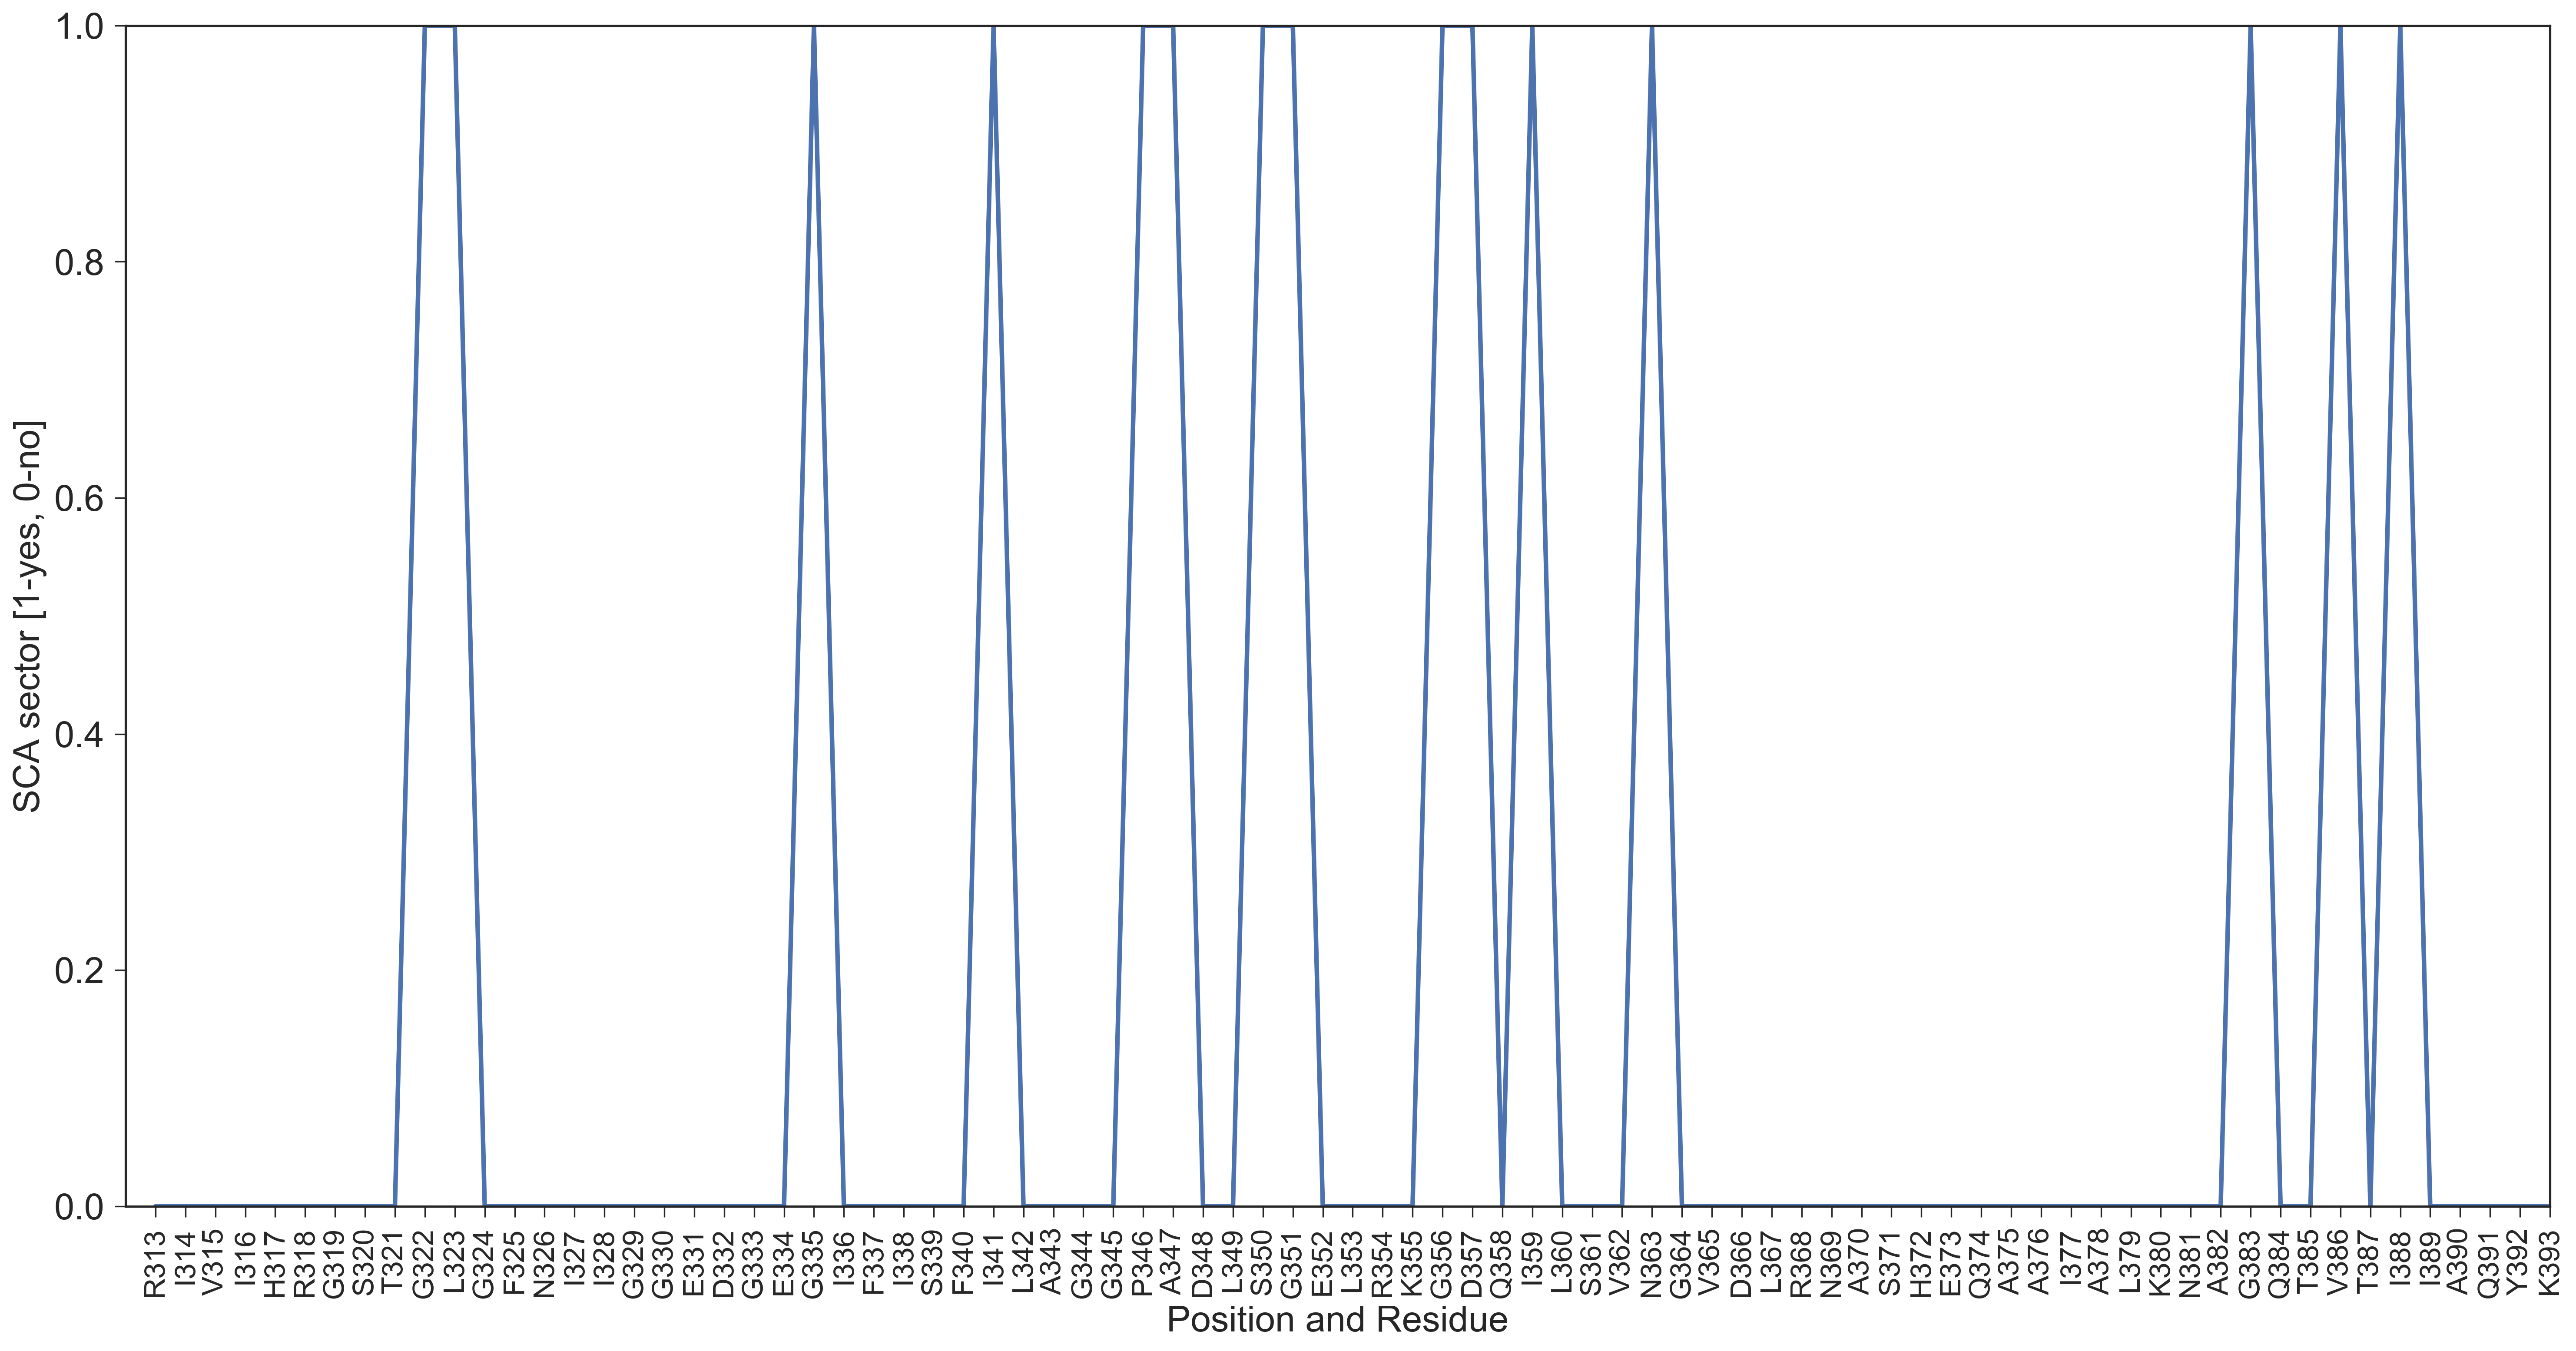

In [7]:
# Generate SCA result plot
sca_resi = [322,323,335,341,346,347,350,351,356,357,359,363,383,386,388]

seaborn.set_style("white")
seaborn.set_style("ticks")
seaborn.set_context("paper",rc={"lines.linewidth": 2.5})
sca_attn = numpy.zeros(SEQ_LENGTH)
for i in range(0,len(sca_resi)):
    sca_resi[i] = sca_resi[i]-313
    sca_attn[sca_resi[i]] = 1


# Activation Plot
f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax = seaborn.tsplot(data=sca_attn);
ax.set_ylabel("SCA sector [1-yes, 0-no]", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

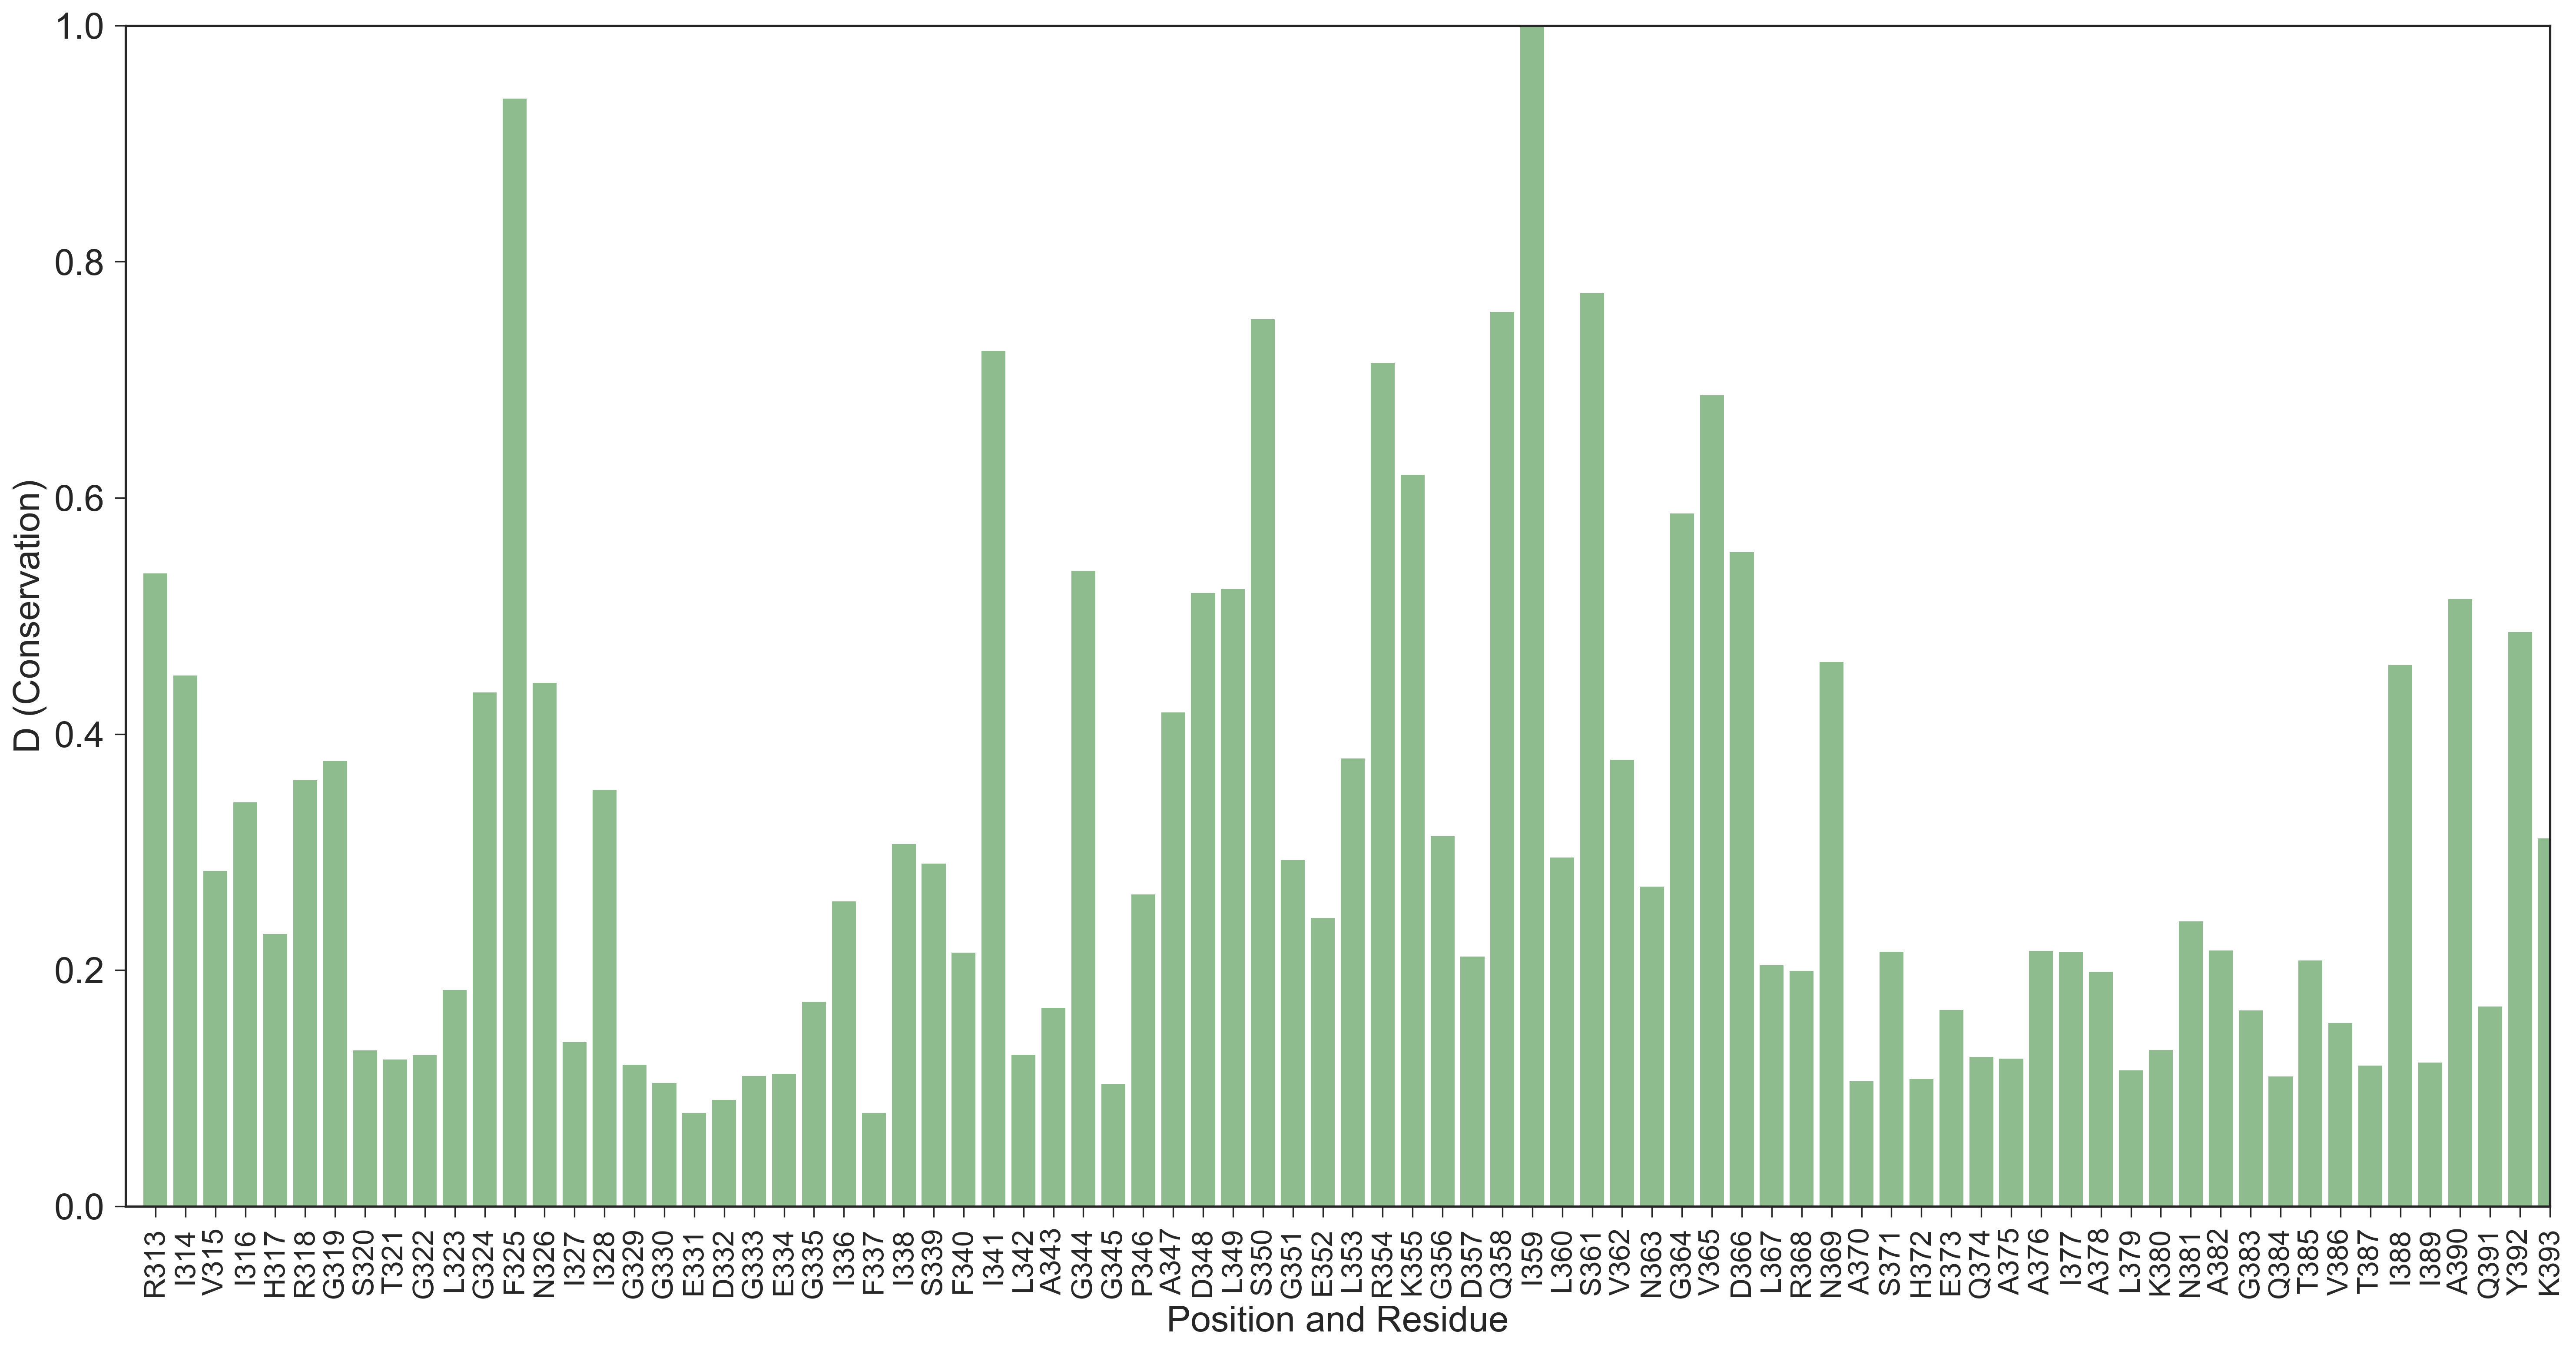

In [8]:
# Conservation plot
#  A global measure of conservation is similarly measured by D(f(i)||q') (where q' takes into
# account gaps, see Note 103, Section III.D)
D_glo =numpy.asarray([1.39722835428465,1.17131452863579,0.740166866801338,0.891828497506467,0.600682929843461,0.940988815893989,0.982645538606472,0.343991252509171,0.324084633476947,0.333289677866532,0.477066346066248,1.13416436717007,2.44487299756565,1.15559841648559,0.362752886086542,0.919197339086053,0.312170116132950,0.271964579357982,0.206253342795471,0.234618292757086,0.287206605901162,0.292046349031535,0.451348191080937,0.673438980752825,0.206516368923654,0.800017586045462,0.756346503585753,0.560072930431289,1.88781935878327,0.334603392228855,0.438428494485861,1.40300853884778,0.269311464063226,0.688683561927367,1.08976753015303,1.35409672341706,1.36239264784420,1.95799319171362,0.764493130332398,0.637056537780983,0.988523407999968,1.86076036437285,1.61451578057001,0.817144630540806,0.550871939783863,1.97455018722258,2.60635685601595,0.770094447668683,2.01538084285858,0.985439127497449,0.705980414799517,1.52923279530180,1.78986163120469,1.44366771985395,0.532324389334263,0.519489888788719,1.20104764645072,0.275695636613718,0.561452722320122,0.280944634865812,0.432976580106781,0.329384613985788,0.326327312939904,0.563345251447735,0.561196952178436,0.517915777928205,0.300171208796443,0.345395419920129,0.628592727198740,0.564631982887215,0.432187883895986,0.286761788482137,0.543107389265377,0.404848006156374,0.310927270680671,1.19514668683441,0.317342688558085,1.34061923846071,0.440931129958831,1.26785550006758,0.812228396912236])
D_glo = normalize(D_glo.reshape(-1, 1),norm='max',axis=0).ravel()

f, ax = plt.subplots(figsize=(24,12), dpi=300);
ax1 = ax.bar(nums,D_glo, color='darkseagreen');
ax.set_ylabel("D (Conservation)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

F1: 0.8271604938271605 ROC AUC: 0.6597222222222222


(0, 1)

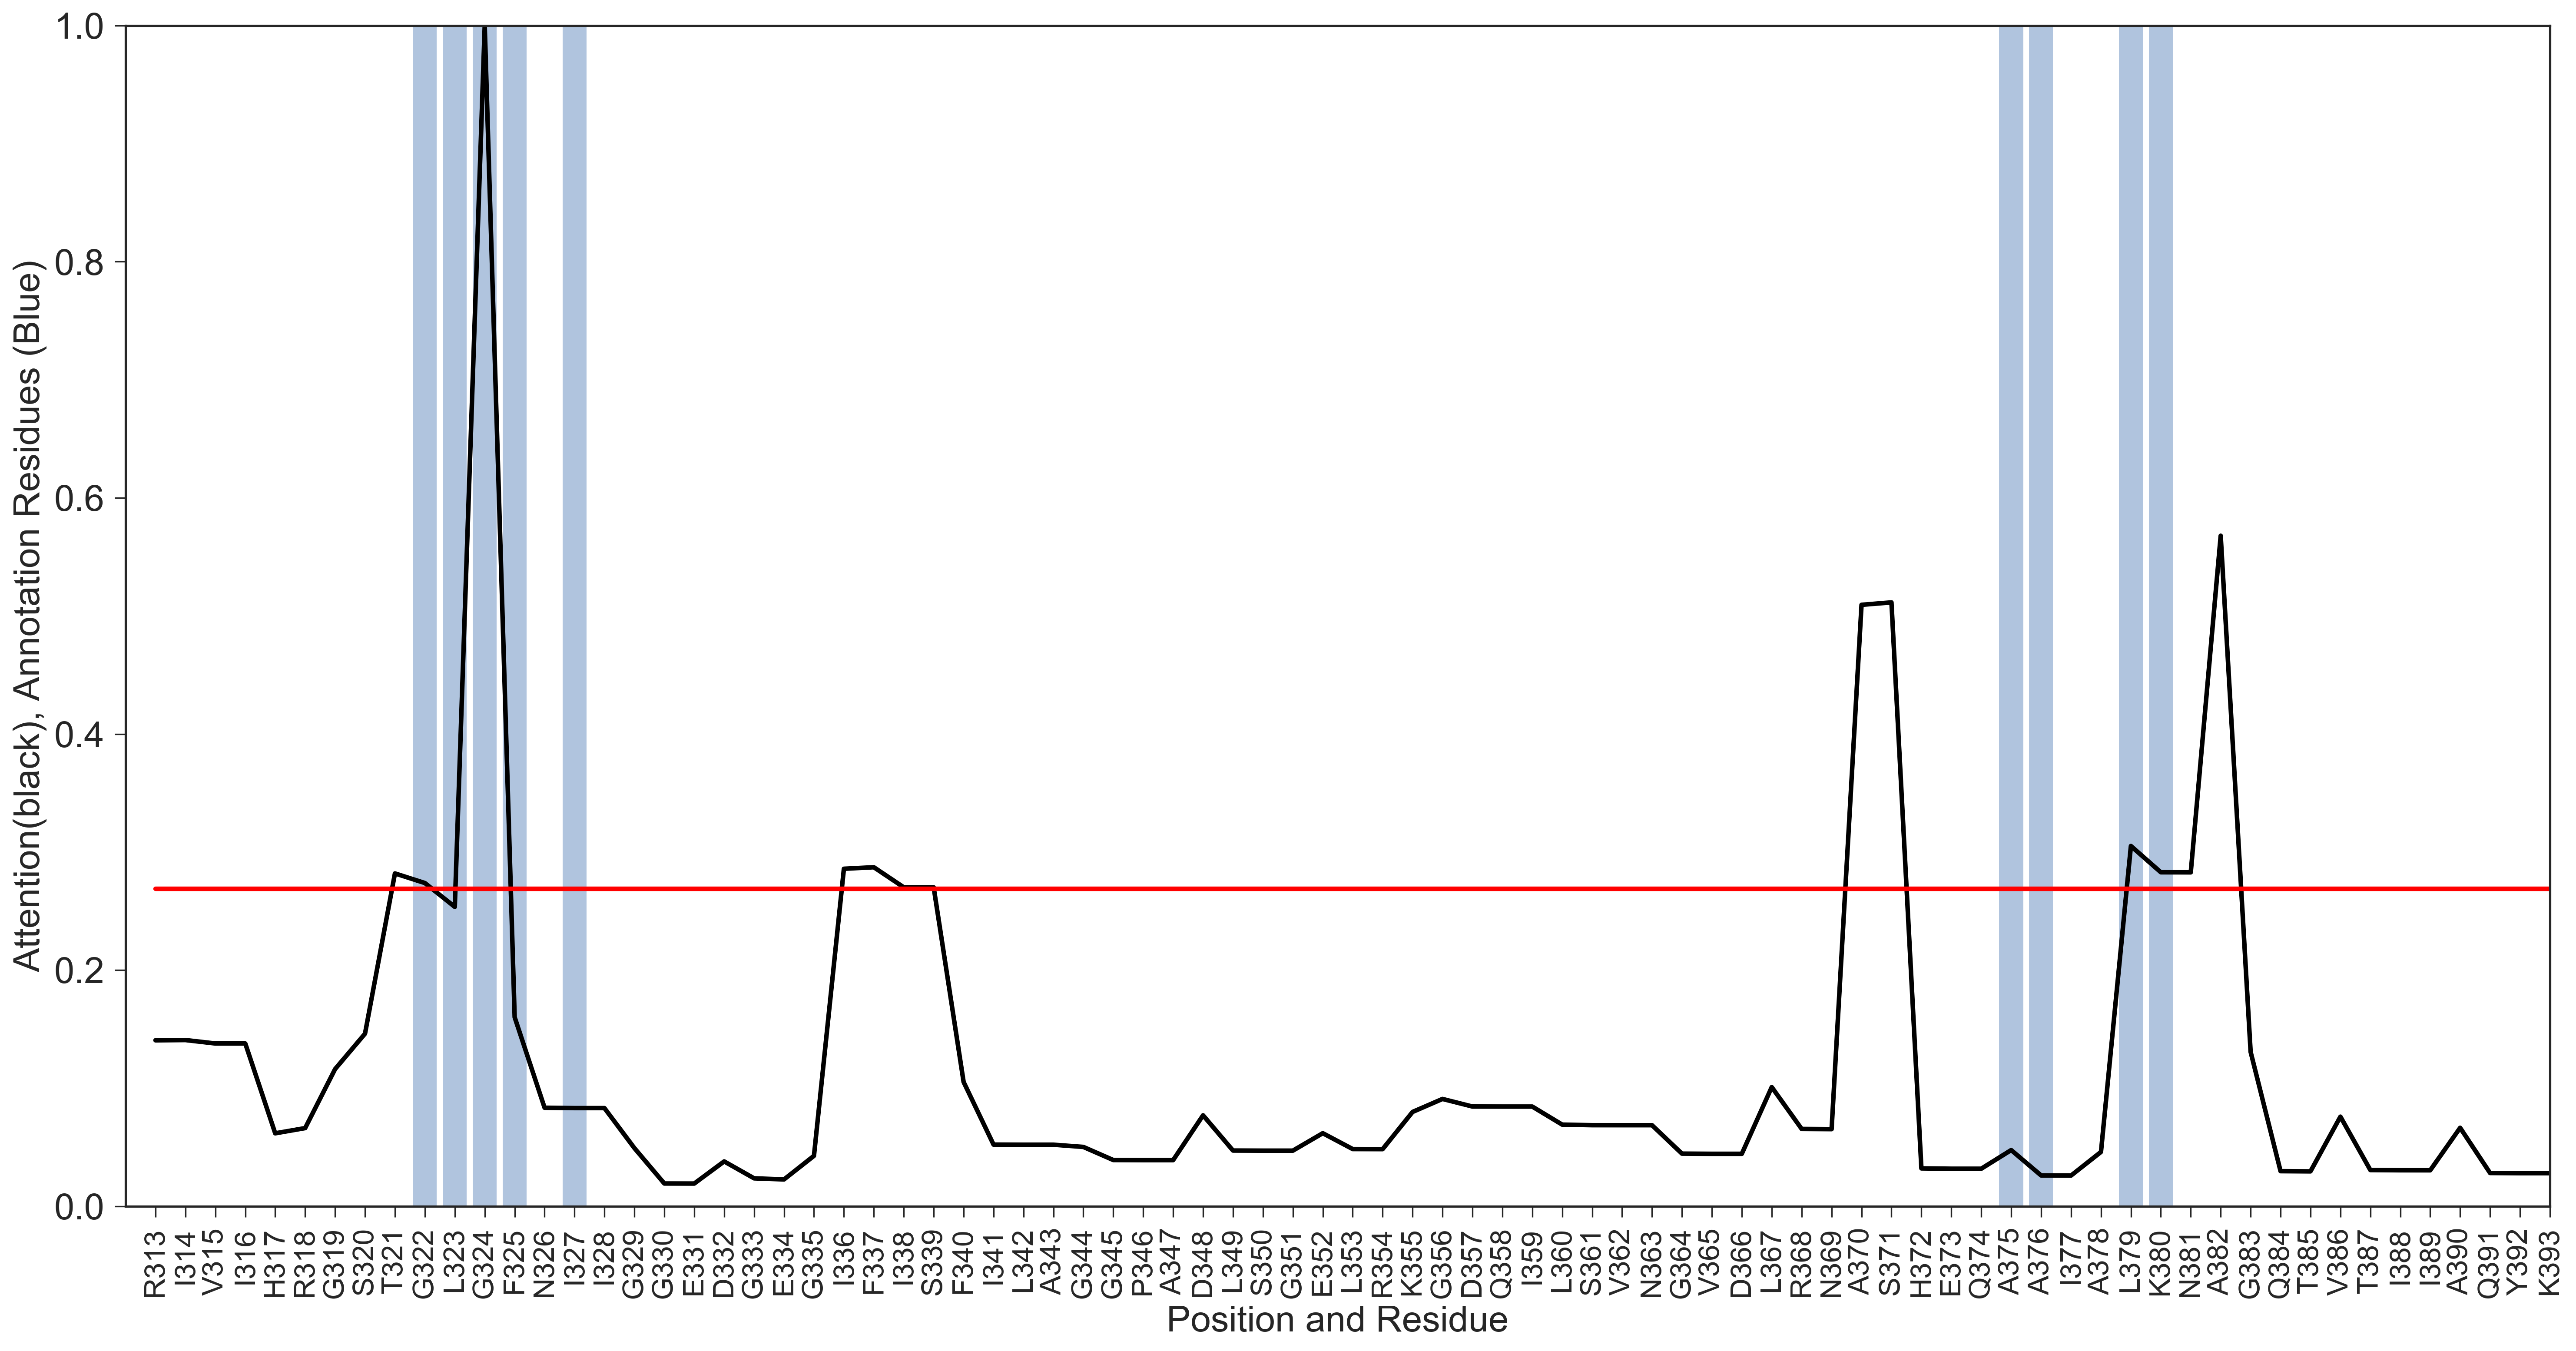

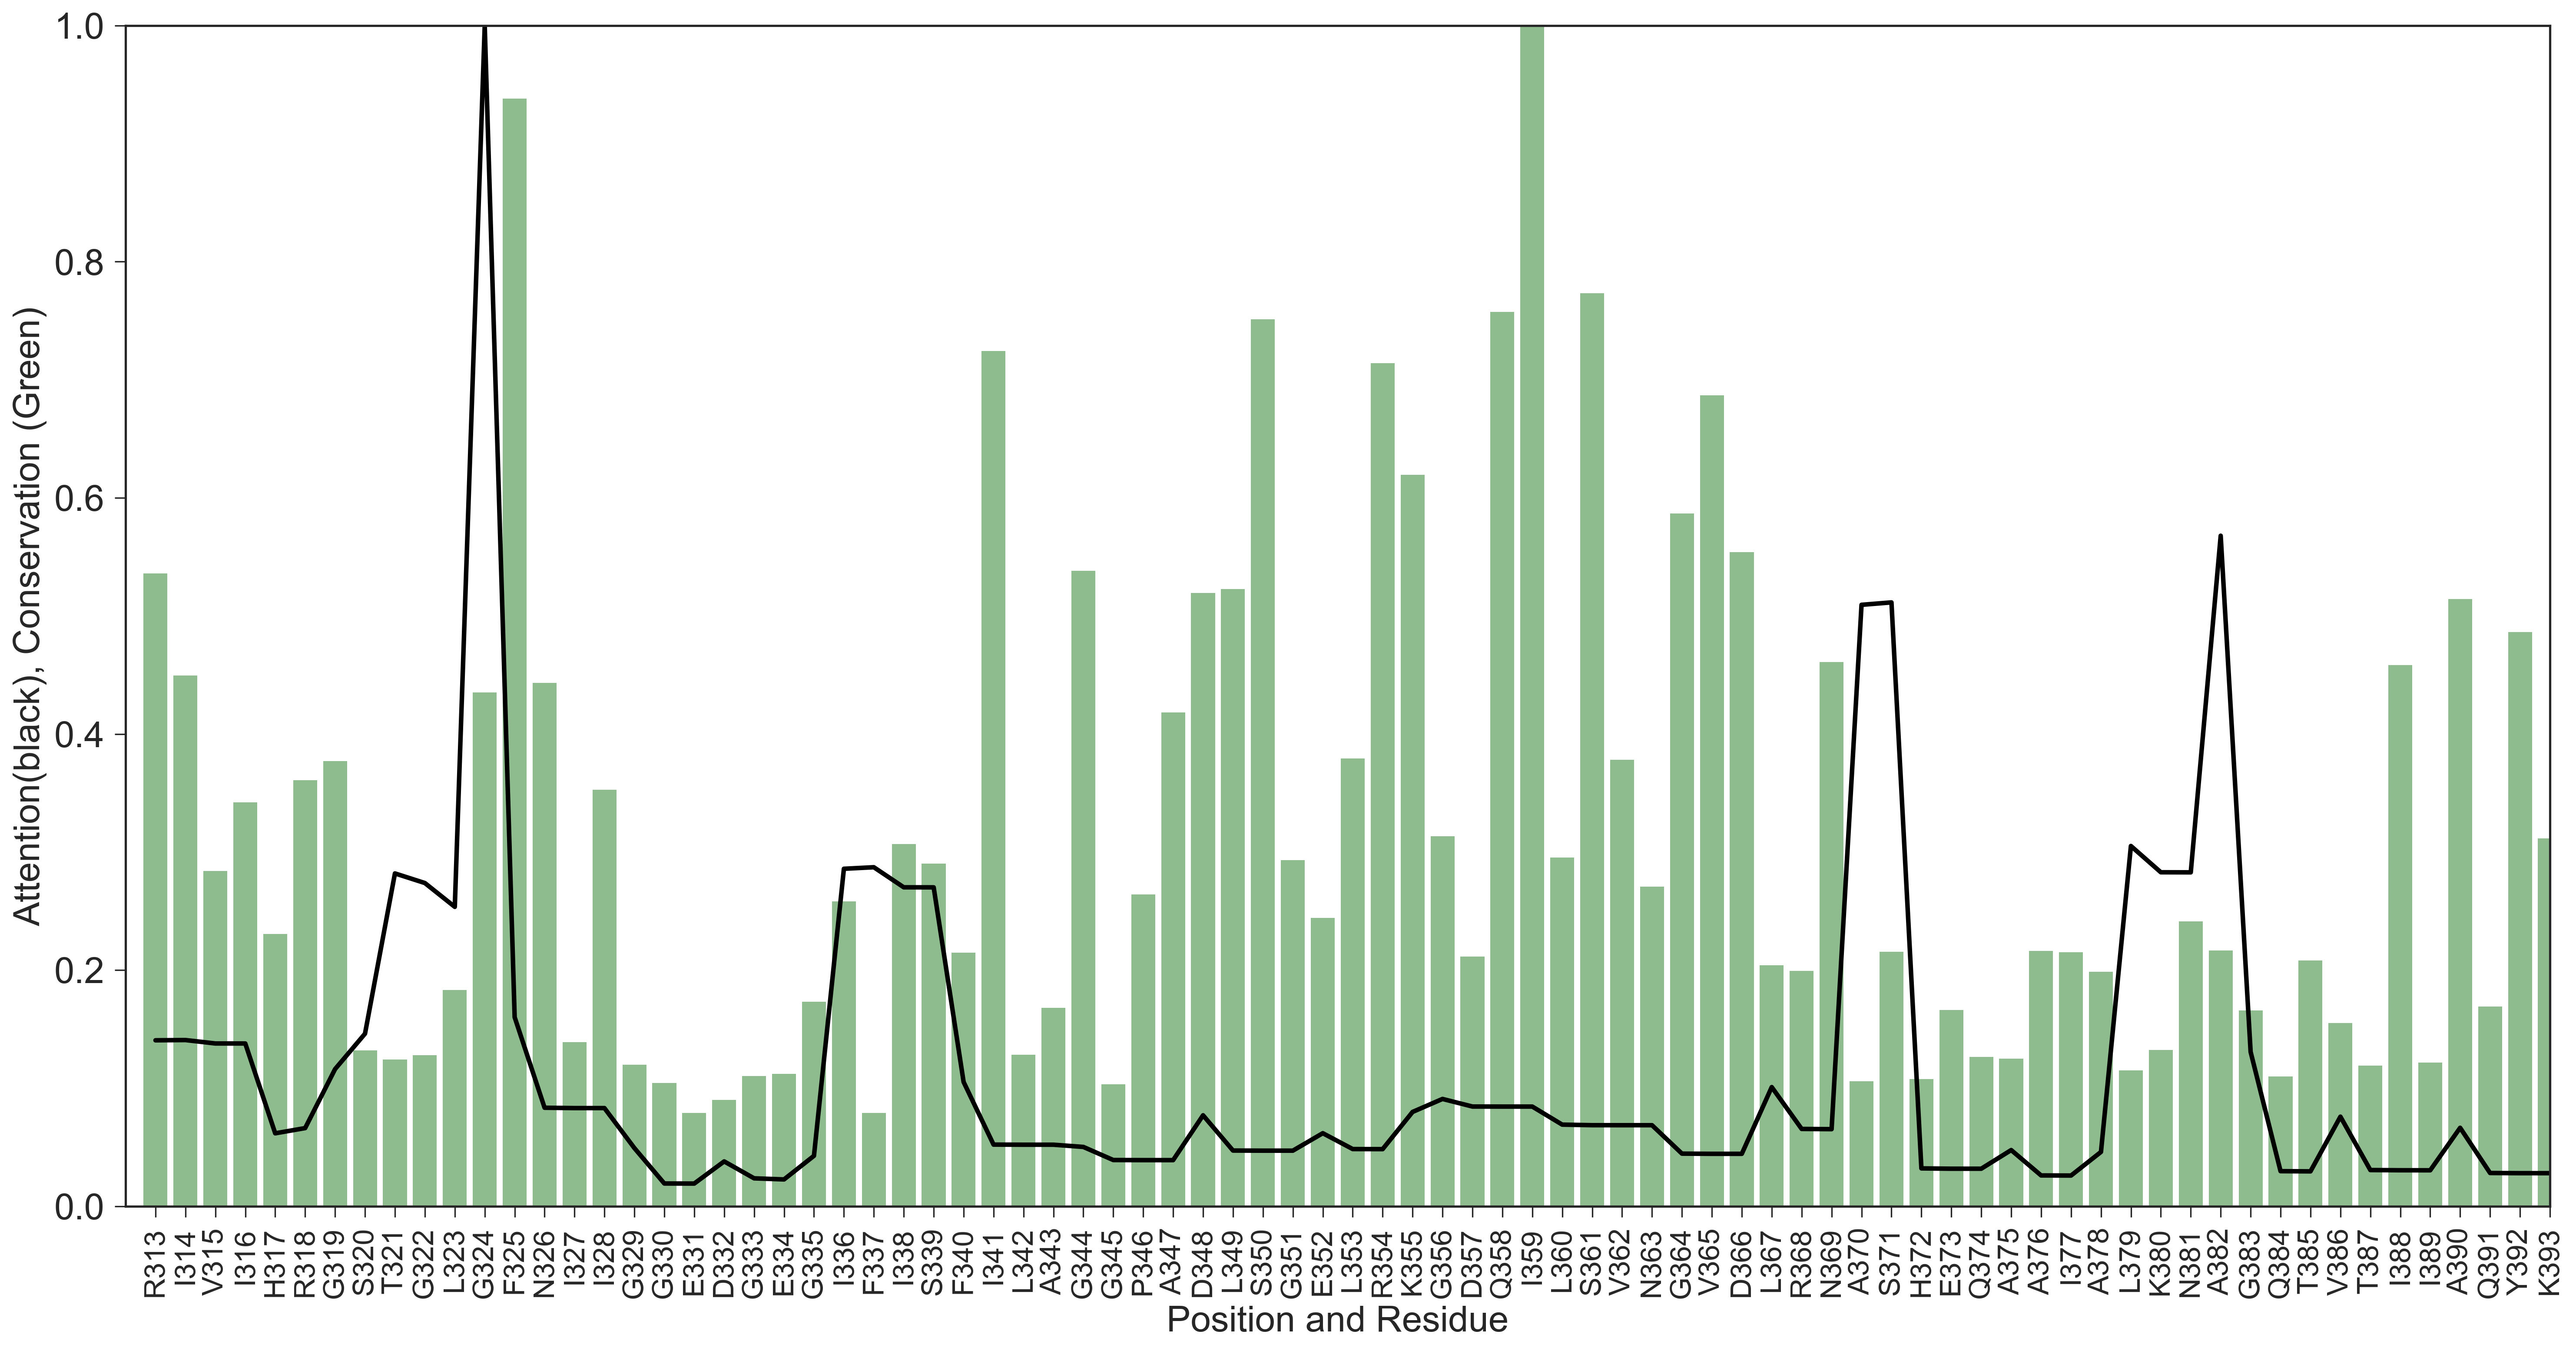

In [11]:
# Generate plots showing attention residues from annotations (in blue), HANprot result (in black)
# and HANprot against conservation (green and black)
from sklearn import metrics
seq_dict = numpy.arange(SEQ_LENGTH)

y = numpy.array([0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0])
# Make attn = 1 if >0.1
y_ = numpy.zeros(SEQ_LENGTH)
y_ =[1*(data_[i]>(numpy.mean(data_)+1*numpy.std(data_))) for i in range(0,SEQ_LENGTH)  ]


data_auc=metrics.auc(nums, y_)
y_auc=metrics.auc(nums, y_)
roc_auc = metrics.roc_auc_score(y,numpy.array(y_))
from sklearn.metrics import f1_score
f1=f1_score(y,numpy.array(y_), average='micro')  
print("F1:", f1,"ROC AUC:", roc_auc)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,y, color='lightsteelblue');
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
threshold = (numpy.mean(data_)+1*numpy.std(data_))*numpy.ones(SEQ_LENGTH)
ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = plt.bar(nums,D_glo, color='darkseagreen');
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Conservation (Green)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)


(0, 1)

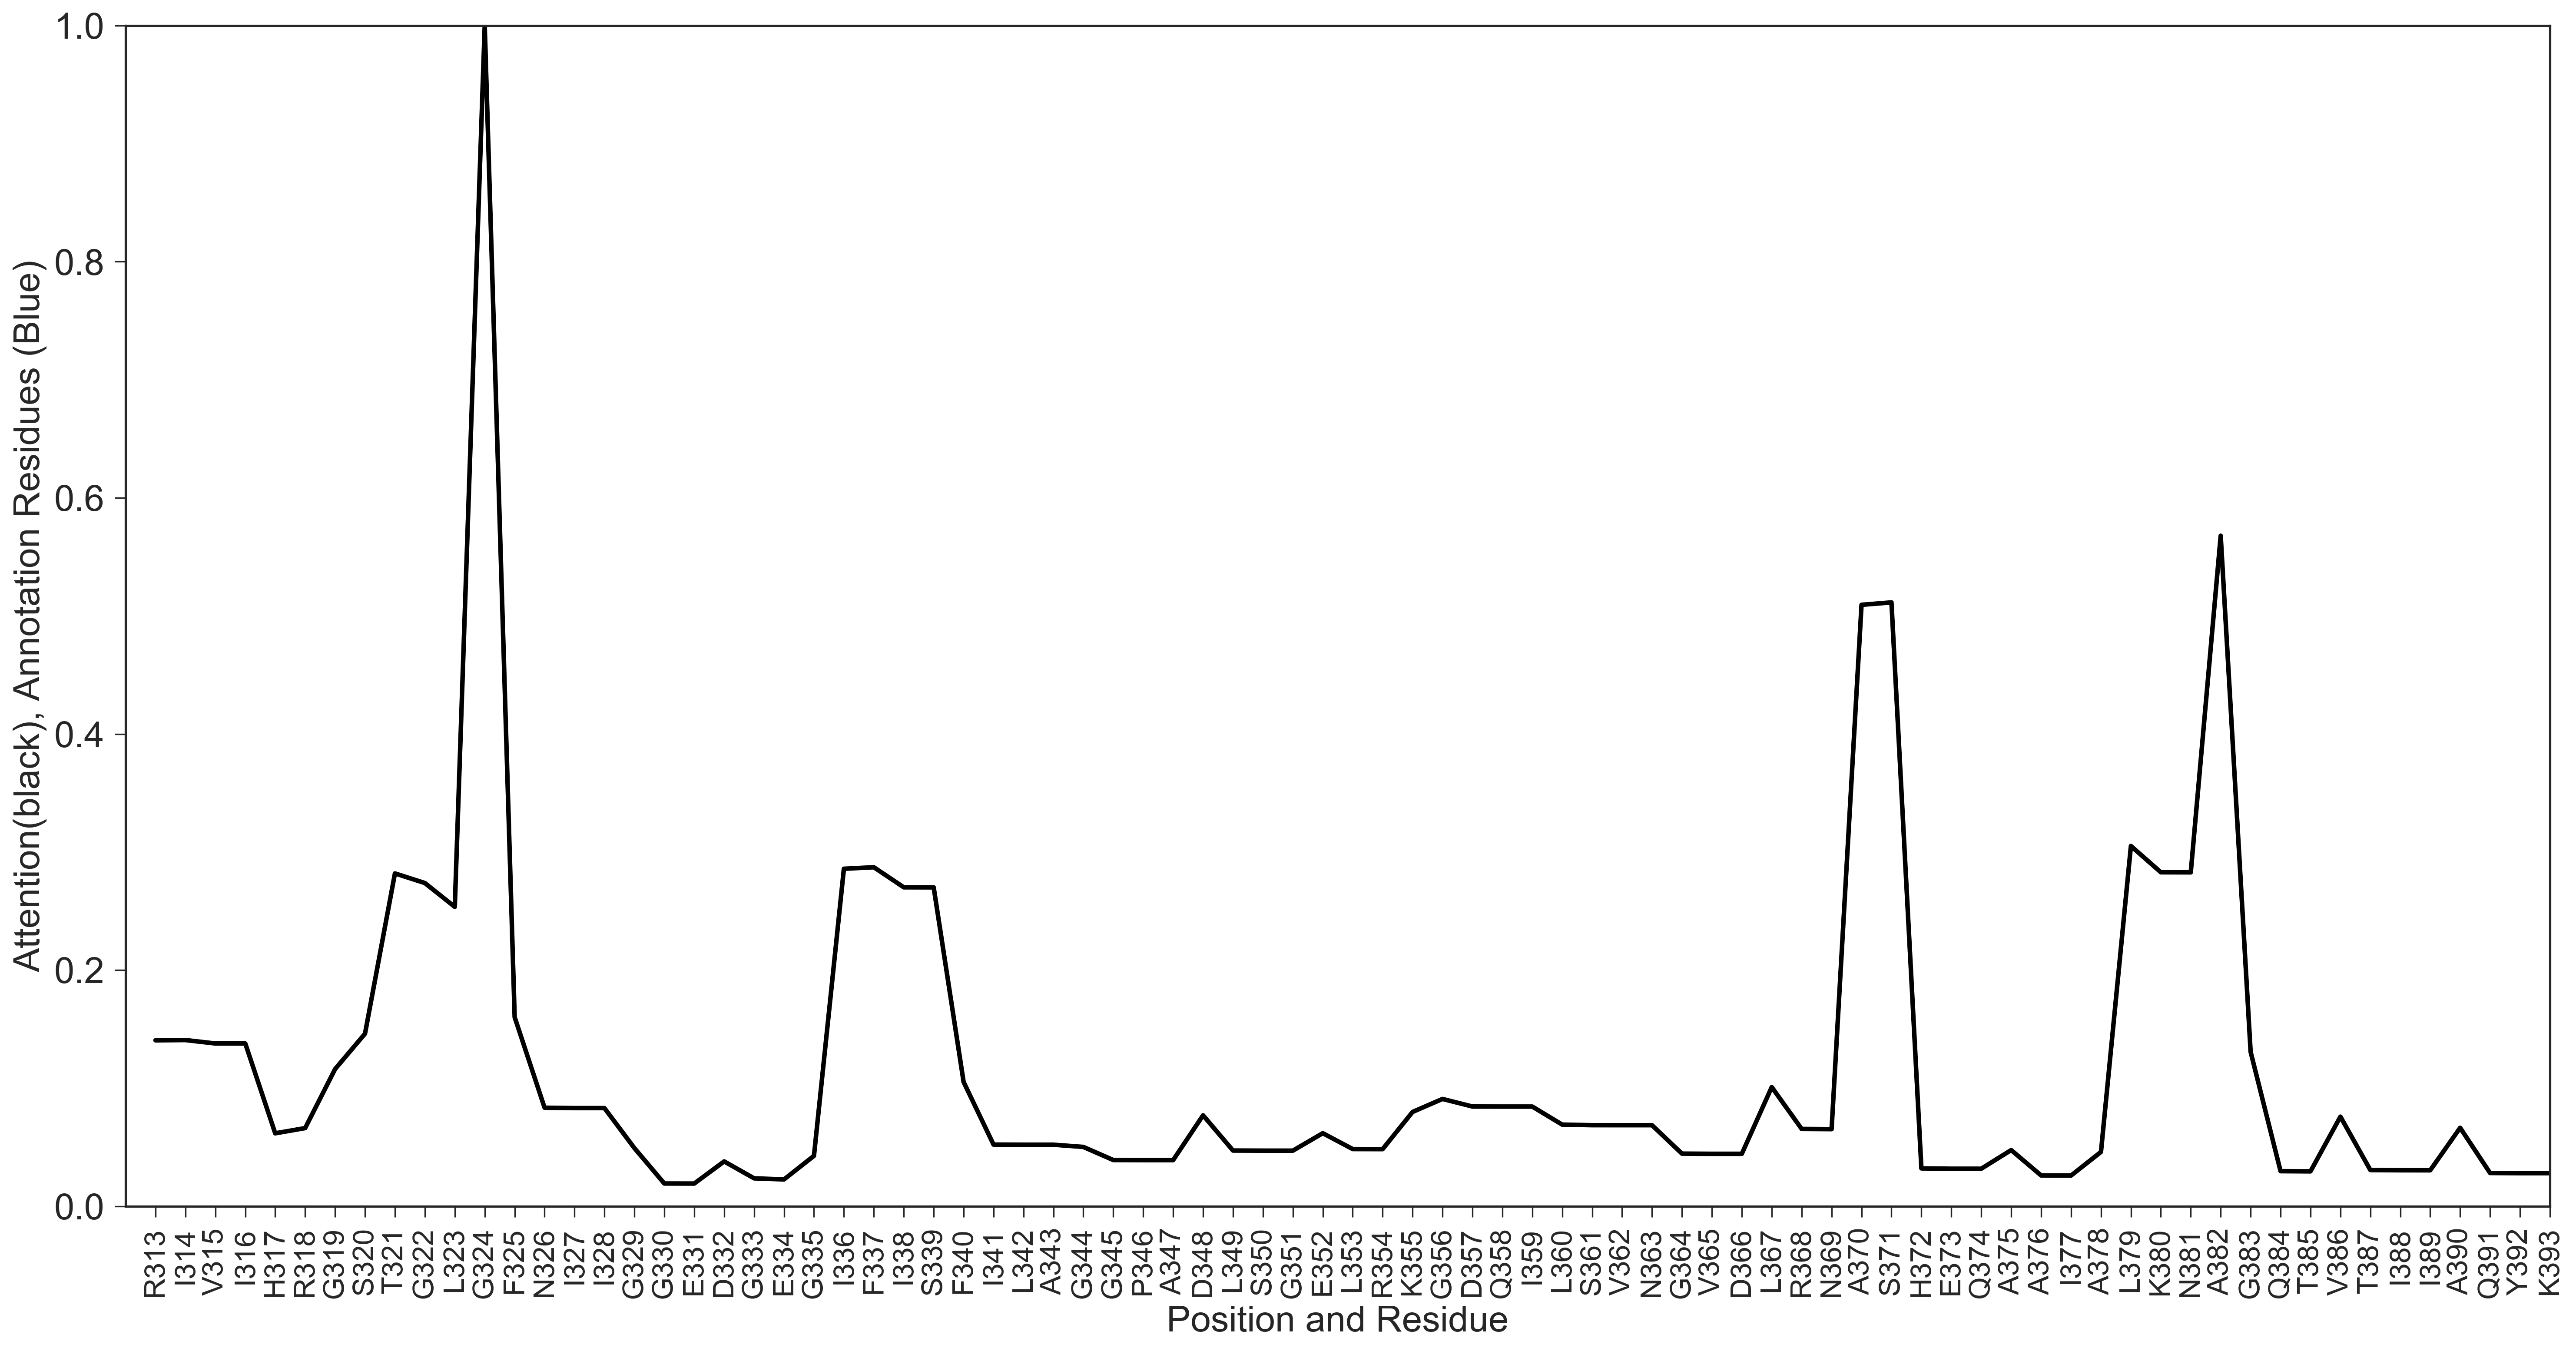

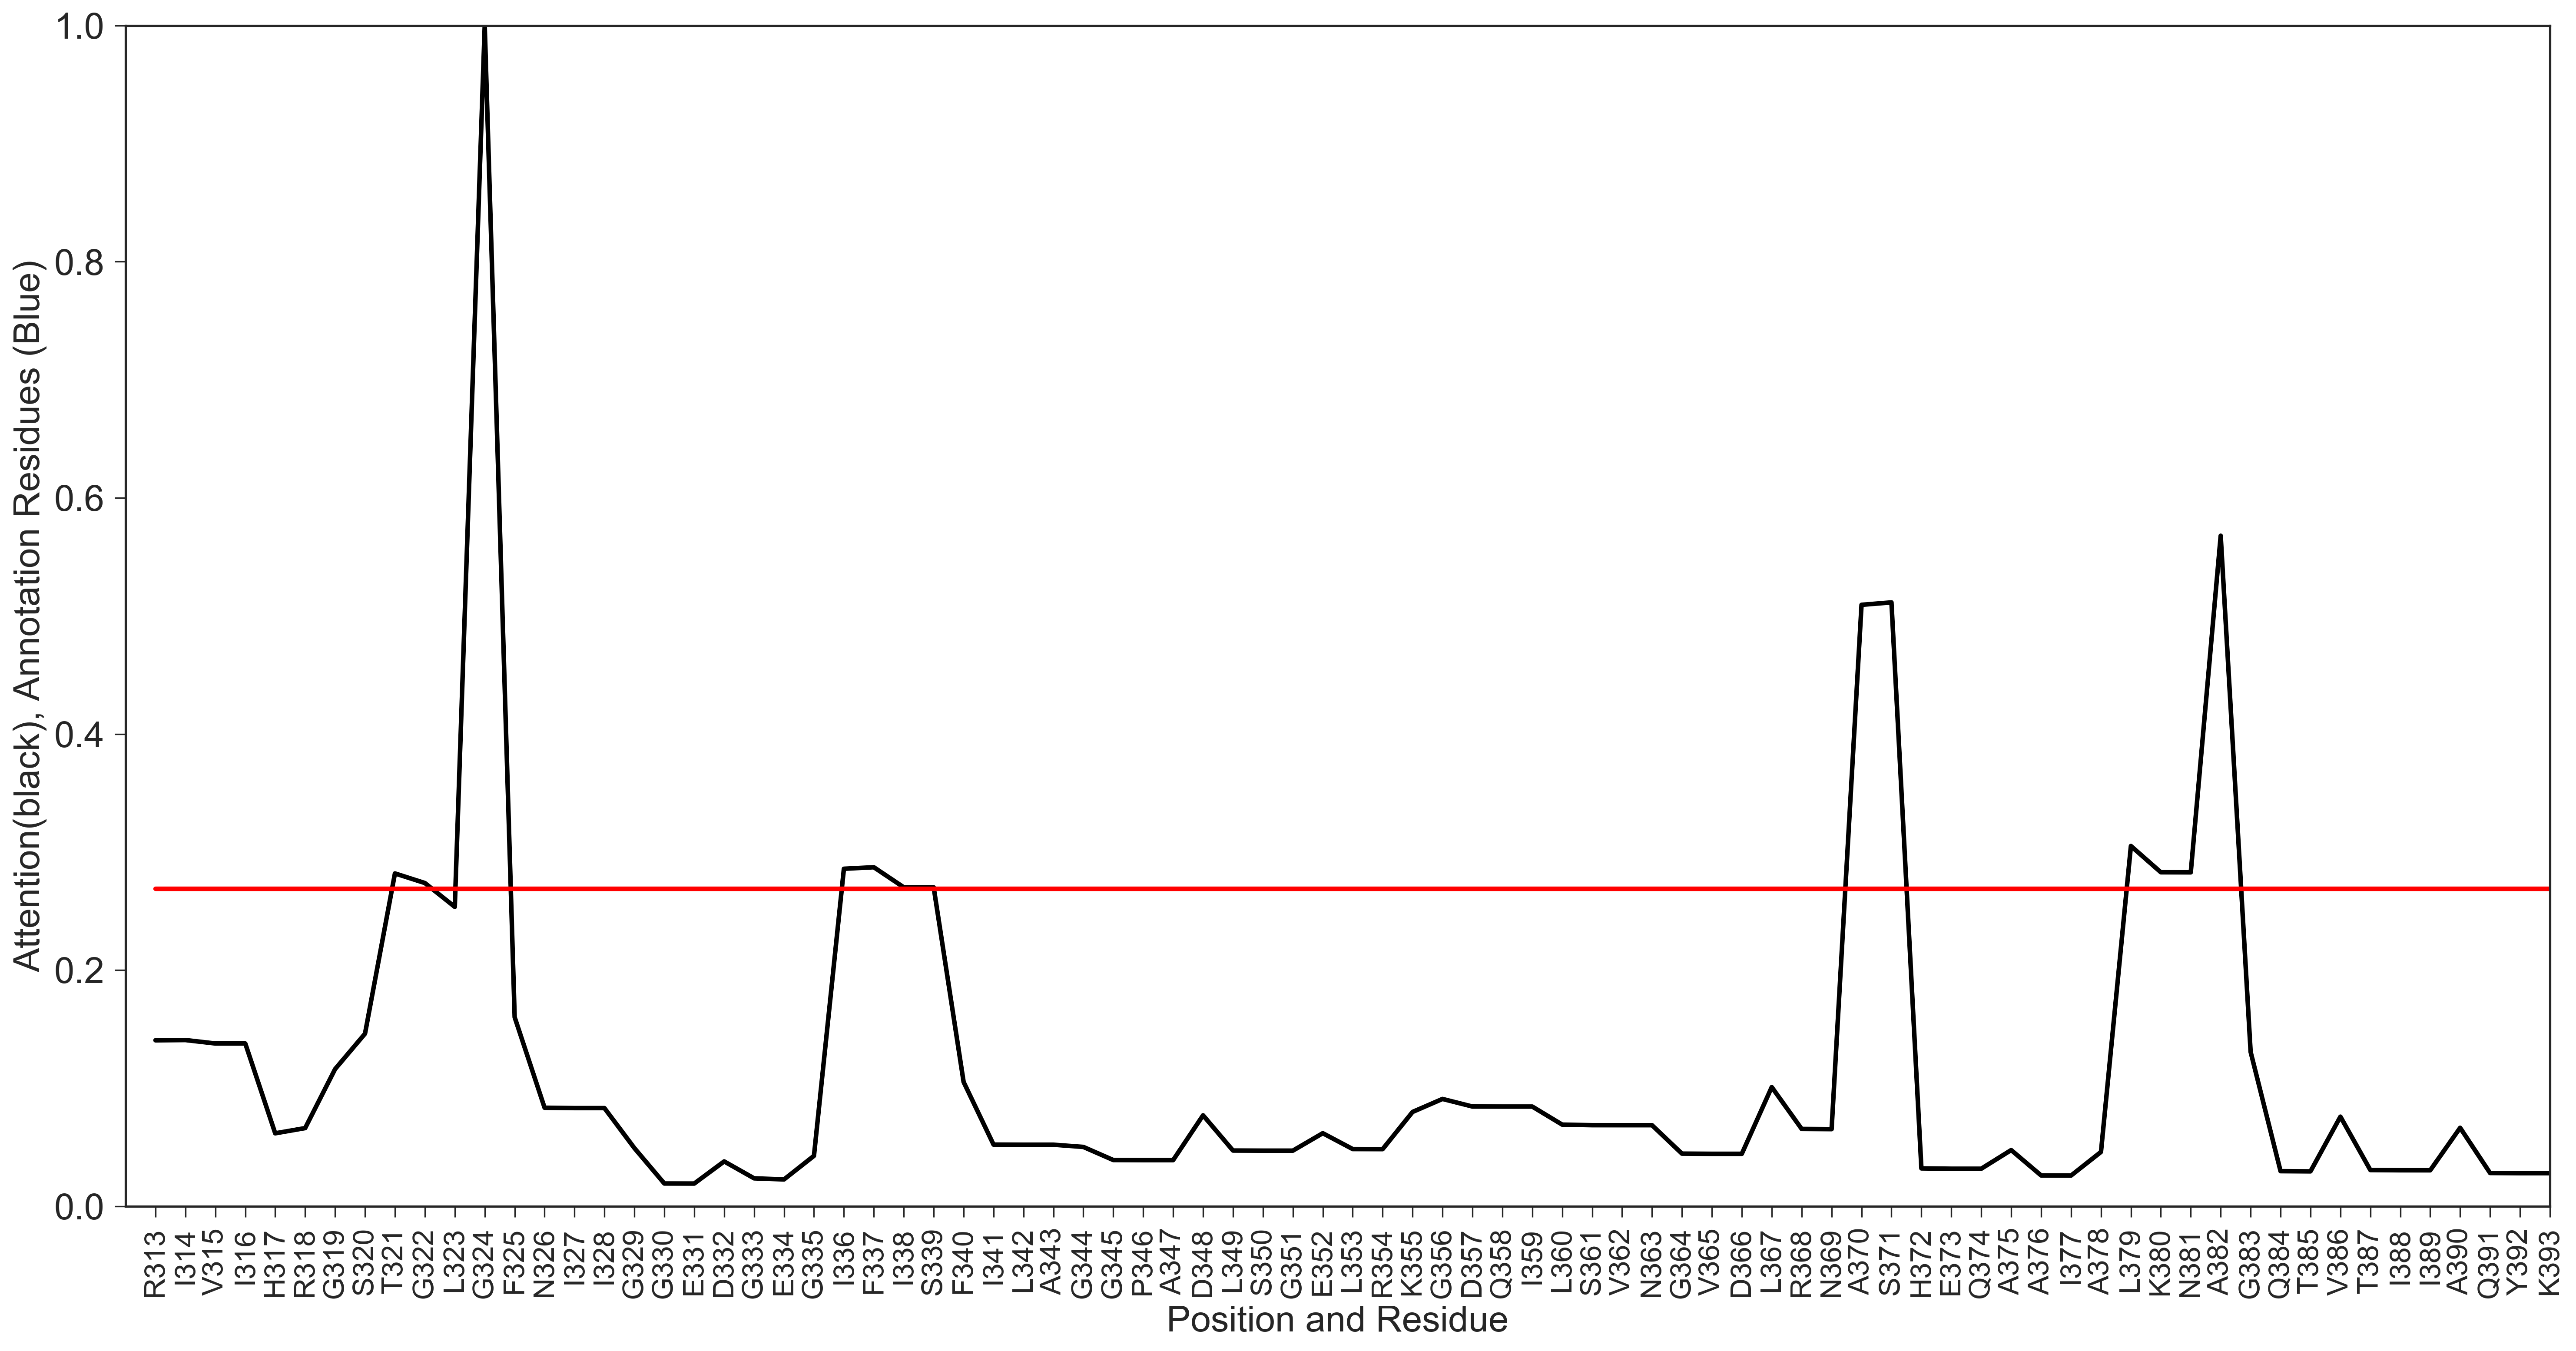

In [10]:
# Generate plot showing Attn residues and threshold
f, ax = plt.subplots(figsize=(24,12),dpi=300);
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
# threshold = (numpy.mean(data_)+1*numpy.std(data_))*numpy.ones(SEQ_LENGTH)
# ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)

f, ax = plt.subplots(figsize=(24,12),dpi=300);
# ax = plt.bar(nums,y, color='lightsteelblue');
ax = seaborn.tsplot(data=data_, color='black');
ax.set_ylabel("Attention(black), Annotation Residues (Blue)", fontsize=20);
ax.set_xlabel("Position and Residue", fontsize=20); 
ax.set_xticks(nums);
ax.set_xticklabels(xticks, rotation=90, fontsize=16);
plt.yticks(fontsize=20);
threshold = (numpy.mean(data_)+1*numpy.std(data_))*numpy.ones(SEQ_LENGTH)
ax.plot(seq_dict,threshold, 'r');
ax.set_xlim(-1,SEQ_LENGTH-1);ax.set_ylim(0,1)